# TomatoMAP-Cls Trainer

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import argparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import ImageDraw, ImageFont, Image
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import (
    MobileNet_V3_Large_Weights,
    MobileNet_V3_Small_Weights,
    MobileNet_V2_Weights,
    ResNet18_Weights,
)

# env checker
print("Environment checker:")
print(f"  PyTorch version: {torch.__version__}")
print(f"  CUDA version: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU device: {torch.cuda.get_device_name(0)}")
    print(f"  GPU ram: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Environment checker:
  PyTorch version: 2.7.1+cu126
  CUDA version: True
  GPU device: Tesla V100-PCIE-16GB
  GPU ram: 15.8 GB


In [2]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"model saved at: {path}")

def load_model(model, path, device='cpu'):
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"model loaded from: {path}")

def save_checkpoint(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def load_checkpoint(path, model, optimizer, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"from epoch {start_epoch} re-training")
    return start_epoch

def get_font(size=30, bold=False):
    font_paths = [
        "C:/Windows/Fonts/arialbd.ttf" if bold else "C:/Windows/Fonts/arial.ttf",
        "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf" if bold else "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
        "/System/Library/Fonts/Supplemental/Arial-Bold.ttf" if bold else "/System/Library/Fonts/Supplemental/Arial.ttf",
    ]
    for path in font_paths:
        try:
            return ImageFont.truetype(path, size=size)
        except:
            continue
    return ImageFont.load_default()

def denormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(img_tensor.device)
    return torch.clamp(img_tensor * std + mean, 0, 1)

def get_model(name, num_classes, pretrained=True):
    print(f"build model: {name}, class number: {num_classes}")
    
    if name == 'mobilenet_v3_large':
        weights = MobileNet_V3_Large_Weights.DEFAULT if pretrained else None
        model = models.mobilenet_v3_large(weights=weights)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    elif name == 'mobilenet_v3_small':
        weights = MobileNet_V3_Small_Weights.DEFAULT if pretrained else None
        model = models.mobilenet_v3_small(weights=weights)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    elif name == 'mobilenet_v2':
        weights = MobileNet_V2_Weights.DEFAULT if pretrained else None
        model = models.mobilenet_v2(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == 'resnet18':
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        model = models.resnet18(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Model {name} not supported.")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"parameter info: Total: {total_params:,}, Trainable: {trainable_params:,}")
    
    return model

class BBCHDataset(Dataset):
    
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(f"Directory not found: {self.data_dir}")
        
        # get all classes
        self.classes = sorted([d for d in os.listdir(self.data_dir)
                              if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))
        
        print(f"loading {split} dataset: {len(self.samples)} images, {len(self.classes)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"failed to load image: {img_path}, error: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# data enhance
def get_transforms(target_size=(640, 640)):
    train_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def get_dataloaders(data_dir, batch_size=32, target_size=(640, 640), num_workers=8, include_test=False):
    print(f"building dataloader: {data_dir}")
    
    train_transform, val_transform = get_transforms(target_size)
    
    train_dataset = BBCHDataset(data_dir, 'train', train_transform)
    val_dataset = BBCHDataset(data_dir, 'val', val_transform)

    # for windows users
    import platform
    if platform.system() == 'Windows':
        num_workers = 0
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=torch.cuda.is_available()
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=torch.cuda.is_available()
    )
    
    test_loader = None
    if include_test:
        test_dir = os.path.join(data_dir, 'test')
        if os.path.exists(test_dir):
            test_dataset = BBCHDataset(data_dir, 'test', val_transform)
            test_loader = DataLoader(
                test_dataset, batch_size=batch_size, shuffle=False,
                num_workers=num_workers, pin_memory=torch.cuda.is_available()
            )
        else:
            print("test set not found, using val as test")
            test_loader = val_loader

    return train_loader, val_loader, test_loader

In [3]:
CLASSIFICATION_CONFIG = {
    'data_dir': 'TomatoMAP/TomatoMAP-Cls',
    'model_name': 'mobilenet_v3_large',  # 'mobilenet_v3_small', 'mobilenet_v2', 'resnet18'
    'num_classes': 50,
    'batch_size': 32,
    'num_epochs': 30,
    'learning_rate': 1e-4,
    'target_size': (640, 640),
    'patience': 3,
    'save_interval': 20
}

print("config:")
for key, value in CLASSIFICATION_CONFIG.items():
    print(f"  {key}: {value}")

config:
  data_dir: TomatoMAP/TomatoMAP-Cls
  model_name: mobilenet_v3_large
  num_classes: 50
  batch_size: 32
  num_epochs: 30
  learning_rate: 0.0001
  target_size: (640, 640)
  patience: 3
  save_interval: 20


TomatoMAP-Cls Trainer
data founded at: TomatoMAP/TomatoMAP-Cls
TomatoMAP-Cls is well structured.

 training config:
   data_dir: TomatoMAP/TomatoMAP-Cls
   model_name: mobilenet_v3_large
   num_classes: 50
   batch_size: 32
   num_epochs: 30
   learning_rate: 0.0001
   target_size: (640, 640)
   patience: 3
   save_interval: 20

 training start.
Using device: cuda
building dataloader: TomatoMAP/TomatoMAP-Cls
loading train dataset: 45099 images, 50 classes
loading val dataset: 12870 images, 50 classes
loading test dataset: 6495 images, 50 classes
build model: mobilenet_v3_large, class number: 50
parameter info: Total: 4,266,082, Trainable: 4,266,082
Training start with 30 epoch(s),


Epoch 1/30 [Val]: 100%|████████████████████| 403/403 [01:00<00:00,  6.67it/s, Loss=1.8581, Acc=40.05%]



 Epoch 1/30:
  Train - Loss: 2.1123, Acc: 32.31%
  Val - Loss: 1.6768, Acc: 40.05%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 40.05%
------------------------------------------------------------


Epoch 2/30 [Val]: 100%|████████████████████| 403/403 [01:07<00:00,  5.99it/s, Loss=0.9373, Acc=45.84%]



 Epoch 2/30:
  Train - Loss: 1.6399, Acc: 42.30%
  Val - Loss: 1.4930, Acc: 45.84%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 45.84%
------------------------------------------------------------


Epoch 3/30 [Val]: 100%|████████████████████| 403/403 [01:00<00:00,  6.64it/s, Loss=0.9665, Acc=47.71%]



 Epoch 3/30:
  Train - Loss: 1.4578, Acc: 47.10%
  Val - Loss: 1.4351, Acc: 47.71%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 47.71%
------------------------------------------------------------


Epoch 4/30 [Val]: 100%|████████████████████| 403/403 [01:06<00:00,  6.06it/s, Loss=1.2630, Acc=53.02%]



 Epoch 4/30:
  Train - Loss: 1.3072, Acc: 51.96%
  Val - Loss: 1.2602, Acc: 53.02%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 53.02%
------------------------------------------------------------


Epoch 5/30 [Val]: 100%|████████████████████| 403/403 [01:00<00:00,  6.63it/s, Loss=1.0445, Acc=54.39%]



 Epoch 5/30:
  Train - Loss: 1.1802, Acc: 56.47%
  Val - Loss: 1.2064, Acc: 54.39%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 54.39%
------------------------------------------------------------


Epoch 6/30 [Val]: 100%|████████████████████| 403/403 [01:02<00:00,  6.47it/s, Loss=0.5300, Acc=58.96%]



 Epoch 6/30:
  Train - Loss: 1.0670, Acc: 60.32%
  Val - Loss: 1.0961, Acc: 58.96%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 58.96%
------------------------------------------------------------


Epoch 7/30 [Val]: 100%|████████████████████| 403/403 [01:04<00:00,  6.29it/s, Loss=0.5100, Acc=60.51%]



 Epoch 7/30:
  Train - Loss: 0.9635, Acc: 64.10%
  Val - Loss: 1.0496, Acc: 60.51%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 60.51%
------------------------------------------------------------


Epoch 8/30 [Val]: 100%|████████████████████| 403/403 [01:00<00:00,  6.68it/s, Loss=0.4854, Acc=62.77%]



 Epoch 8/30:
  Train - Loss: 0.8680, Acc: 67.50%
  Val - Loss: 0.9902, Acc: 62.77%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 62.77%
------------------------------------------------------------


Epoch 9/30 [Val]: 100%|████████████████████| 403/403 [01:01<00:00,  6.58it/s, Loss=0.3427, Acc=64.92%]



 Epoch 9/30:
  Train - Loss: 0.7869, Acc: 70.62%
  Val - Loss: 0.9535, Acc: 64.92%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 64.92%
------------------------------------------------------------


Epoch 10/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.55it/s, Loss=0.1160, Acc=66.73%]



 Epoch 10/30:
  Train - Loss: 0.7029, Acc: 73.65%
  Val - Loss: 0.8825, Acc: 66.73%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 66.73%
------------------------------------------------------------


Epoch 11/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.68it/s, Loss=0.9800, Acc=70.13%]



 Epoch 11/30:
  Train - Loss: 0.6342, Acc: 76.41%
  Val - Loss: 0.8193, Acc: 70.13%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 70.13%
------------------------------------------------------------


Epoch 12/30 [Val]: 100%|███████████████████| 403/403 [00:59<00:00,  6.74it/s, Loss=0.5220, Acc=69.18%]



 Epoch 12/30:
  Train - Loss: 0.5705, Acc: 78.85%
  Val - Loss: 0.8643, Acc: 69.18%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 13/30 [Val]: 100%|███████████████████| 403/403 [00:59<00:00,  6.76it/s, Loss=0.4900, Acc=70.23%]



 Epoch 13/30:
  Train - Loss: 0.5188, Acc: 80.82%
  Val - Loss: 0.8389, Acc: 70.23%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 70.23%
------------------------------------------------------------


Epoch 14/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.53it/s, Loss=0.1427, Acc=72.19%]



 Epoch 14/30:
  Train - Loss: 0.4690, Acc: 82.79%
  Val - Loss: 0.7842, Acc: 72.19%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 72.19%
------------------------------------------------------------


Epoch 15/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.67it/s, Loss=0.0423, Acc=73.65%]



 Epoch 15/30:
  Train - Loss: 0.4207, Acc: 84.51%
  Val - Loss: 0.7464, Acc: 73.65%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 73.65%
------------------------------------------------------------


Epoch 16/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.59it/s, Loss=0.0441, Acc=74.16%]



 Epoch 16/30:
  Train - Loss: 0.3839, Acc: 86.13%
  Val - Loss: 0.7422, Acc: 74.16%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 74.16%
------------------------------------------------------------


Epoch 17/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.60it/s, Loss=0.0240, Acc=73.03%]



 Epoch 17/30:
  Train - Loss: 0.3403, Acc: 87.79%
  Val - Loss: 0.8209, Acc: 73.03%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 18/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.67it/s, Loss=0.0083, Acc=75.19%]



 Epoch 18/30:
  Train - Loss: 0.3198, Acc: 88.62%
  Val - Loss: 0.7634, Acc: 75.19%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 75.19%
------------------------------------------------------------


Epoch 19/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.68it/s, Loss=0.2833, Acc=75.68%]



 Epoch 19/30:
  Train - Loss: 0.2938, Acc: 89.24%
  Val - Loss: 0.7364, Acc: 75.68%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 75.68%
------------------------------------------------------------


Epoch 20/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.57it/s, Loss=0.0088, Acc=74.93%]



 Epoch 20/30:
  Train - Loss: 0.2635, Acc: 90.42%
  Val - Loss: 0.7816, Acc: 74.93%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 21/30 [Val]: 100%|███████████████████| 403/403 [01:03<00:00,  6.33it/s, Loss=0.7884, Acc=76.23%]



 Epoch 21/30:
  Train - Loss: 0.2497, Acc: 91.08%
  Val - Loss: 0.7626, Acc: 76.23%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 76.23%
------------------------------------------------------------


Epoch 22/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.64it/s, Loss=0.0347, Acc=75.87%]



 Epoch 22/30:
  Train - Loss: 0.2265, Acc: 92.02%
  Val - Loss: 0.8087, Acc: 75.87%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 23/30 [Val]: 100%|███████████████████| 403/403 [01:06<00:00,  6.06it/s, Loss=0.2525, Acc=76.99%]



 Epoch 23/30:
  Train - Loss: 0.2128, Acc: 92.44%
  Val - Loss: 0.7541, Acc: 76.99%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 76.99%
------------------------------------------------------------


Epoch 24/30 [Val]: 100%|███████████████████| 403/403 [01:05<00:00,  6.11it/s, Loss=0.0584, Acc=77.33%]



 Epoch 24/30:
  Train - Loss: 0.2004, Acc: 92.88%
  Val - Loss: 0.7255, Acc: 77.33%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 77.33%
------------------------------------------------------------


Epoch 25/30 [Val]: 100%|███████████████████| 403/403 [01:04<00:00,  6.23it/s, Loss=0.0602, Acc=77.47%]



 Epoch 25/30:
  Train - Loss: 0.1869, Acc: 93.45%
  Val - Loss: 0.7610, Acc: 77.47%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 77.47%
------------------------------------------------------------


Epoch 26/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.58it/s, Loss=0.0157, Acc=78.09%]



 Epoch 26/30:
  Train - Loss: 0.1716, Acc: 93.95%
  Val - Loss: 0.7465, Acc: 78.09%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 78.09%
------------------------------------------------------------


Epoch 27/30 [Val]: 100%|███████████████████| 403/403 [00:59<00:00,  6.73it/s, Loss=0.2581, Acc=77.28%]



 Epoch 27/30:
  Train - Loss: 0.1627, Acc: 94.37%
  Val - Loss: 0.7966, Acc: 77.28%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 28/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.62it/s, Loss=0.0969, Acc=79.19%]



 Epoch 28/30:
  Train - Loss: 0.1564, Acc: 94.52%
  Val - Loss: 0.7067, Acc: 79.19%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 79.19%
------------------------------------------------------------


Epoch 29/30 [Val]: 100%|███████████████████| 403/403 [01:04<00:00,  6.28it/s, Loss=0.2542, Acc=77.54%]



 Epoch 29/30:
  Train - Loss: 0.1497, Acc: 94.85%
  Val - Loss: 0.8152, Acc: 77.54%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 30/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.68it/s, Loss=0.1726, Acc=79.02%]



 Epoch 30/30:
  Train - Loss: 0.1404, Acc: 95.06%
  Val - Loss: 0.7246, Acc: 79.02%
  lr: 1.00e-05
  val acc not raised (2/3)
------------------------------------------------------------
model saved at: cls/runs/mobilenet_v3_large_cls/final_mobilenet_v3_large.pth

 TomatoMAP-Cls is trained!
  best val acc: 79.19%
  model saved at: cls/runs/mobilenet_v3_large_cls


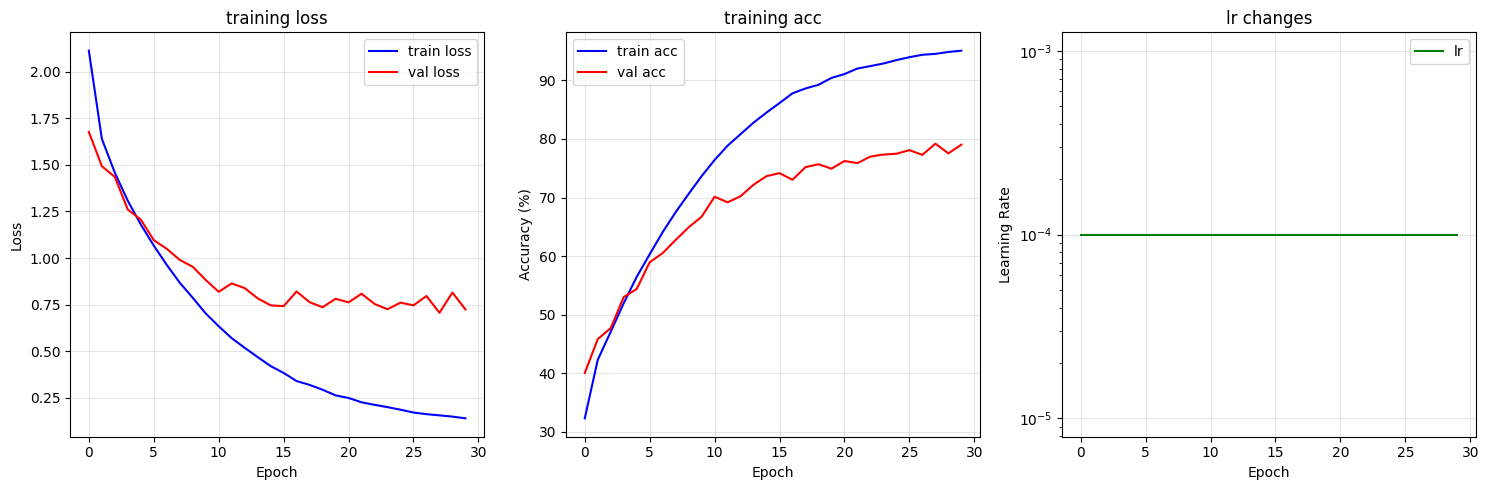

 training log saved at: cls/runs/mobilenet_v3_large_cls/training_history.csv


 training finished!
   best val acc is: 79.19%
   model saved at: cls/runs/mobilenet_v3_large_cls

 evaluating on test subset...


evaluating: 100%|███████████████████████████████████████| 203/203 [00:31<00:00,  6.42it/s, Acc=79.01%]


 test subset acc: 79.01%

 building confusion matrix


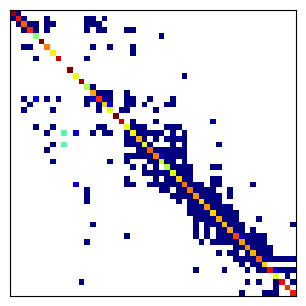


 Evaluation results:
   best val acc: 79.19%
   test acc: 79.01%
   class number: 50
   test data size: 6495
   results saved at: cls/runs/mobilenet_v3_large_cls
   GGWP!


In [4]:
def train_model(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    output_dir = Path(f"cls/runs/{config['model_name']}_cls")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    train_loader, val_loader, test_loader = get_dataloaders(
        config['data_dir'], 
        batch_size=config['batch_size'],
        target_size=config['target_size'],
        num_workers=8,
        include_test=True
    )
    
    model = get_model(config['model_name'], config['num_classes'], pretrained=True)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=0.01)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience_counter = 0
    
    print(f"Training start with {config['num_epochs']} epoch(s),")
    
    for epoch in range(config['num_epochs']):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]")
        
        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            current_acc = 100 * train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Val]")
            
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                current_acc = 100 * val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.2f}%'
                })
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\n Epoch {epoch+1}/{config['num_epochs']}:")
        print(f"  Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Val - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%")
        print(f"  lr: {current_lr:.2e}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = output_dir / f"best_{config['model_name']}.pth"
            save_model(model, best_model_path)
            patience_counter = 0
            print(f"  best val acc: {best_val_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"  val acc not raised ({patience_counter}/{config['patience']})")
        
        if (epoch + 1) % config['save_interval'] == 0:
            checkpoint_path = output_dir / f"checkpoint_epoch_{epoch+1}.pth"
            save_checkpoint(model, optimizer, epoch, checkpoint_path)
        
        if patience_counter >= config['patience']:
            print(f"\n Trigger early stop. Val acc has {config['patience']} epochs no improve")
            break
        
        print("-" * 60)
    
    final_model_path = output_dir / f"final_{config['model_name']}.pth"
    save_model(model, final_model_path)
    
    print(f"\n TomatoMAP-Cls is trained!")
    print(f"  best val acc: {best_val_acc:.2f}%")
    print(f"  model saved at: {output_dir}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='train loss', color='blue')
    plt.plot(val_losses, label='val loss', color='red')
    plt.title('training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='train acc', color='blue')
    plt.plot(val_accuracies, label='val acc', color='red')
    plt.title('training acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    lrs = []
    for i in range(len(train_losses)):
        if i < 30:
            lrs.append(config['learning_rate'])
        elif i < 60:
            lrs.append(config['learning_rate'] * 0.1)
        else:
            lrs.append(config['learning_rate'] * 0.01)
    plt.plot(lrs, label='lr', color='green')
    plt.title('lr changes')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    history_df = pd.DataFrame({
        'epoch': range(1, len(train_losses) + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    })
    history_df.to_csv(output_dir / 'training_history.csv', index=False)
    print(f" training log saved at: {output_dir / 'training_history.csv'}")
    
    return model, best_val_acc, output_dir, test_loader


print("=" * 60)
print("TomatoMAP-Cls Trainer")
print("=" * 60)

if not os.path.exists(CLASSIFICATION_CONFIG['data_dir']):
    print(f"dataset not exist")
    print(f"   path: {CLASSIFICATION_CONFIG['data_dir']}")
    print(f"   please check data structure")
else:
    print(f"data founded at: {CLASSIFICATION_CONFIG['data_dir']}")
    
    train_dir = os.path.join(CLASSIFICATION_CONFIG['data_dir'], 'train')
    val_dir = os.path.join(CLASSIFICATION_CONFIG['data_dir'], 'val')
    test_dir = os.path.join(CLASSIFICATION_CONFIG['data_dir'], 'test')
    
    if not os.path.exists(train_dir):
        print(f"training subset not exist: {train_dir}")
    elif not os.path.exists(val_dir):
        print(f"val subset not exist: {val_dir}")
    elif not os.path.exists(test_dir):
        print(f"test subset not exist: {test_dir}")
        print(f"   using val subset for test")
    else:
        print(f"TomatoMAP-Cls is well structured.")
        
        print("\n training config:")
        for key, value in CLASSIFICATION_CONFIG.items():
            print(f"   {key}: {value}")
        
        print("\n training start.")
        
        try:
            model, best_acc, output_dir, test_loader = train_model(CLASSIFICATION_CONFIG)
            
            print("\n" + "=" * 60)
            print("\n training finished!")
            print(f"   best val acc is: {best_acc:.2f}%")
            print(f"   model saved at: {output_dir}")
            
            print("\n evaluating on test subset...")
            model.eval()
            test_correct = 0
            test_total = 0
            test_predictions = []
            test_labels = []
            
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            
            with torch.no_grad():
                test_pbar = tqdm(test_loader, desc="evaluating")
                for images, labels in test_pbar:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

                    test_predictions.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
                    
                    current_acc = 100 * test_correct / test_total
                    test_pbar.set_postfix({'Acc': f'{current_acc:.2f}%'})
            
            test_accuracy = 100 * test_correct / test_total
            print(f" test subset acc: {test_accuracy:.2f}%")

            print("\n building confusion matrix")
            
            train_dataset = test_loader.dataset
            class_names = train_dataset.classes
            
            cm = confusion_matrix(test_labels, test_predictions)
            
            cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
            cm_df.to_csv(output_dir / 'confusion_matrix.csv')

            normalized_cm = cm_df.div(cm_df.sum(axis=1), axis=0).fillna(0)
            
            matrix = normalized_cm.T.to_numpy()
            
            from matplotlib import rcParams
            # rcParams['font.family'] = 'Calibri' # Ubuntu doesn't own this when training on ubuntu VM
            rcParams['font.size'] = 8
            
            masked_matrix = np.ma.masked_where(matrix == 0, matrix)
            
            from matplotlib.colors import Normalize
            cmap = plt.cm.jet
            cmap.set_bad(color='white')
            norm = Normalize(vmin=0.1, vmax=1)
            
            fig_width_in = 3.1
            fig_height_in = fig_width_in
            fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))
            
            im = ax.imshow(masked_matrix, cmap=cmap, norm=norm)

            # For further process for publishing purpose, labels are removed :)
            ax.set_xlabel("")
            ax.set_ylabel("")
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            plt.tight_layout()
            plt.savefig(output_dir / 'normalized_confusion_matrix.png', format='png', dpi=300)
            plt.show()
            
            # plt.figure(figsize=(12, 10))
            # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
            # disp.plot(cmap='Blues', values_format='d')
            # plt.title(f'Detailed Confusion Matrix (test acc: {test_accuracy:.2f}%)', fontsize=8)
            # plt.xticks(rotation=45, ha='right')
            # plt.yticks(rotation=0)
            # plt.tight_layout()
            # plt.savefig(output_dir / 'detailed_confusion_matrix.png', dpi=300, bbox_inches='tight')
            # plt.show()
            
            test_results = {
                'test_accuracy': test_accuracy,
                'total_samples': test_total,
                'correct_predictions': test_correct,
                'num_classes': len(class_names),
                'class_names': class_names
            }
            
            import json
            with open(output_dir / 'test_results.json', 'w', encoding='utf-8') as f:
                json.dump(test_results, f, indent=2, ensure_ascii=False)
            
            print("\n" + "=" * 60)
            print(" Evaluation results:")
            print(f"   best val acc: {best_acc:.2f}%")
            print(f"   test acc: {test_accuracy:.2f}%")
            print(f"   class number: {len(class_names)}")
            print(f"   test data size: {test_total}")
            print(f"   results saved at: {output_dir}")
            print(f"   GGWP!")
            print("=" * 60)
            
        except KeyboardInterrupt:
            print("\n training interruptted")
            
        except Exception as e:
            print(f"\n error during training:")
            print(f"   error info: {str(e)}")
            print("\nDetails:")
            import traceback
            traceback.print_exc()

# TomatoMAP-Det Trainer

In [3]:
from ultralytics import YOLO
from ultralytics import RTDETR
import torch
# using proper libiary?
import ultralytics
ultralytics.checks()
print(ultralytics.__file__)

Ultralytics 8.3.63 🚀 Python-3.10.0 torch-2.7.1+cu126 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
Setup complete ✅ (24 CPUs, 113.0 GB RAM, 117.4/145.2 GB disk)
/home/ubuntu/project/EoC/code/det/ultralytics/__init__.py


In [4]:
torch.use_deterministic_algorithms(False)

print("\n" + "=" * 60)
print("TomatoMAP-Det Trainer")
print("\n" + "=" * 60)

print("downloading pretrained model: ")

model = YOLO("yolo11l.pt")

print("model info: ")

train_result = model.train(
    data="det/TomatoMAP-Det.yaml",
    epochs=500,
    imgsz=640,
    device=[0],
    batch=4,
    patience=10,
    project="det/output",
    cfg="det/best_hyperparameters.yaml", # fine-tuned hyperparameters, ready to use, details please contact us per email
    #profile=True,
    plots=True
)


TomatoMAP-Det Trainer

downloading pretrained model: 


100%|██████████████████████████████████████████████████████████████████████████████| 49.0M/49.0M [00:01<00:00, 32.8MB/s]


model info: 
New https://pypi.org/project/ultralytics/8.3.167 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.10.0 torch-2.7.1+cu126 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=det/TomatoMAP-Det.yaml, epochs=500, time=None, patience=10, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=det/output, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None,

100%|██████████████████████████████████████████████████████████████████████████████| 5.26M/5.26M [00:00<00:00, 30.5MB/s]


AMP: checks passed ✅


train: Scanning /home/ubuntu/project/EoC/code/TomatoMAP/TomatoMAP-Det/labels/test.cache... 64463 images, 1 backgrounds, 
val: Scanning /home/ubuntu/project/EoC/code/TomatoMAP/TomatoMAP-Det/labels/test.cache... 64463 images, 1 backgrounds, 0 


Plotting labels to det/output/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00089' and 'momentum=0.6' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.00016), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to det/output/train
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      3.34G     0.7181     0.9323      0.937         29        640: 100%|██████████| 16116/16116 [41:42<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8058/8058 [09


                   all      64464     583417      0.818      0.495      0.527      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      3.71G     0.6265     0.6749     0.8621         48        640: 100%|██████████| 16116/16116 [39:27<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8058/8058 [08


                   all      64464     583417      0.587      0.568      0.578      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      3.68G     0.6143     0.6485     0.8528         49        640:  41%|████      | 6558/16116 [15:46<22:59,


KeyboardInterrupt: 

# TomatoMAP-Seg Trainer

In [1]:
import os
import cv2
import json
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from pathlib import Path
from collections import OrderedDict

# Detectron2
import detectron2
from detectron2.engine import DefaultTrainer, DefaultPredictor, HookBase
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.events import get_event_storage
from detectron2.utils.logger import setup_logger

setup_logger()

print(f"  Detectron2 version: {detectron2.__version__}")

  Detectron2 version: 0.6


In [2]:
def flatten_segmentation(points):
    # 把 [[x,y],[x,y]] → [x1,y1,x2,y2,...]
    return [coord for pair in points for coord in pair]

def load_categories_from_yaml(yaml_path):
    with open(yaml_path, 'r', encoding='utf-8') as f:
        data = yaml.safe_load(f)
    categories = []
    cat_map = {}
    cat_id = 1
    for item in data['label']:
        name = item['name']
        if name == '__background__':
            continue
        categories.append({
            "id": cat_id,
            "name": name,
            "supercategory": "none"
        })
        cat_map[name] = cat_id
        cat_id += 1
    return categories, cat_map

def convert_isat_folder_to_coco(task_dir, label_dir, yaml_path, output_dir, train_ratio=0.7, val_ratio=0.2):
    print("ISAT2COCO...")
    
    os.makedirs(output_dir, exist_ok=True)

    categories, category_map = load_categories_from_yaml(yaml_path)
    print(f"loaded {len(categories)} classes")

    if not os.path.exists(task_dir):
        print(f"image folder not exist: {task_dir}")
        return False
    
    if not os.path.exists(label_dir):
        print(f"label folder not exist: {label_dir}")
        return False

    images = [f for f in os.listdir(task_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    json_map = {os.path.splitext(f)[0]: f for f in os.listdir(label_dir) if f.endswith(".json")}

    print(f"found {len(images)} images")
    print(f"found {len(json_map)} labels")

    # 匹配图像和标注
    dataset = []
    unmatched_images = []
    
    for img_name in tqdm(images, desc="匹配图像和标注"):
        base = os.path.splitext(img_name)[0]
        if base in json_map:
            dataset.append({
                "img_file": img_name,
                "json_file": json_map[base]
            })
        else:
            unmatched_images.append(img_name)

    print(f"successfully matched {len(dataset)} pairs")
    if unmatched_images:
        print(f" {len(unmatched_images)} unmatched images")

    if len(dataset) == 0:
        print("no matched pairs")
        return False

    # 设置随机种子以保证可重现性
    random.seed(42)
    random.shuffle(dataset)
    
    total = len(dataset)
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    splits = {
        "train": dataset[:train_end],
        "val": dataset[train_end:val_end],
        "test": dataset[val_end:]
    }

    print(f"\n splitting dataset:")
    for split_name, split_data in splits.items():
        print(f"  {split_name}: {len(split_data)} images ({len(split_data)/total*100:.1f}%)")

    conversion_stats = {}
    
    for split_name, split_data in splits.items():
        if len(split_data) == 0:
            print(f" {split_name} dataset empty, skipping")
            continue
            
        print(f"\n transforming {split_name} dataset...")
        
        coco = {
            "info": {
                "description": "TomatoMAP-Seg Dataset",
                "version": "1.0",
                "year": 2024,
                "contributor": "TomatoMAP-Seg Project",
                "date_created": "2024-01-01"
            },
            "images": [],
            "annotations": [],
            "categories": categories
        }
        ann_id = 1
        img_id = 1
        
        processed_annotations = 0
        skipped_annotations = 0

        for item in tqdm(split_data, desc=f"processing {split_name}"):
            img_path = os.path.join(task_dir, item["img_file"])
            json_path = os.path.join(label_dir, item["json_file"])

            if not os.path.exists(json_path):
                print(f" label file not exist: {json_path}")
                continue

            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    isat = json.load(f)
            except Exception as e:
                print(f"failed to load label file {json_path}: {e}")
                continue

            info = isat['info']
            coco["images"].append({
                "file_name": item["img_file"],
                "id": img_id,
                "width": info["width"],
                "height": info["height"]
            })

            for obj in isat.get('objects', []):
                cat = obj['category']
                if cat not in category_map:
                    skipped_annotations += 1
                    continue

                # 修复 segmentation 点格式
                seg_flat = flatten_segmentation(obj["segmentation"])
                if len(seg_flat) < 6:
                    skipped_annotations += 1
                    continue  # 跳过非法多边形（小于 3 个点）

                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": category_map[cat],
                    "segmentation": [seg_flat],
                    "bbox": obj["bbox"],
                    "area": obj["area"],
                    "iscrowd": obj.get("iscrowd", 0),
                    "group_id": obj.get("group", None)
                })
                ann_id += 1
                processed_annotations += 1
                
            img_id += 1

        output_file = os.path.join(output_dir, f"{split_name}.json")
        with open(output_file, "w", encoding='utf-8') as f:
            json.dump(coco, f, indent=2, ensure_ascii=False)

        conversion_stats[split_name] = {
            'images': len(split_data),
            'annotations': processed_annotations,
            'skipped': skipped_annotations
        }

        print(f"  generated {split_name}.json")
        print(f"     images: {len(split_data)}")
        print(f"     annotations: {processed_annotations}")
        print(f"     skipped: {skipped_annotations}")

    print(f"\n ISAT2COCO finished")
    print(f" output at: {output_dir}")
    print(f" conversion stats:")
    
    total_images = sum(stats['images'] for stats in conversion_stats.values())
    total_annotations = sum(stats['annotations'] for stats in conversion_stats.values())
    total_skipped = sum(stats['skipped'] for stats in conversion_stats.values())
    
    print(f"  total images: {total_images}")
    print(f"  total annotations: {total_annotations}")
    print(f"  skipped annotations: {total_skipped}")
    
    return True

In [3]:
ISAT_CONFIG = {
    'task_dir': "TomatoMAP/TomatoMAP-Seg/images",
    'label_dir': "TomatoMAP/TomatoMAP-Seg/labels",
    'yaml_path': "TomatoMAP/TomatoMAP-Seg/labels/isat.yaml",
    'output_dir': "TomatoMAP/TomatoMAP-Seg/cocoOut",
    'train_ratio': 0.7,
    'val_ratio': 0.2,    # rest 0.1 is test
    'auto_convert': True
}

DATASET_CONFIG = {
    'dataset_root': "TomatoMAP/TomatoMAP-Seg/",
    'img_dir': "TomatoMAP/TomatoMAP-Seg/images",
    'coco_ann_dir': "TomatoMAP/TomatoMAP-Seg/cocoOut",
    'isat_yaml_path': "TomatoMAP/TomatoMAP-Seg/labels/isat.yaml",
    'output_dir': "TomatoMAP/TomatoMAP-Seg/output",
    'num_classes': 10,    # without background
}

TRAINING_CONFIG = {
    'model_name': "mask_rcnn_R_50_FPN_1x",
    'batch_size': 4,
    'base_lr': 0.00024,
    'max_epochs': 100,
    'patience': 15,
    'num_workers': 8,  # Windows user please set to 0
    'score_thresh_test': 0.3,
    'input_min_size_train': (640, 672, 704, 736, 768, 800), 
    'input_max_size_train': 1333,
    'checkpoint_period': 10,
    'eval_period': 10,
}

print("Configurations:")
print("ISAT converter config:")
for key, value in ISAT_CONFIG.items():
    print(f"  {key}: {value}")
print("\n dataset config:")
for key, value in DATASET_CONFIG.items():
    print(f"  {key}: {value}")
print("\n training config:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

Configurations:
ISAT converter config:
  task_dir: TomatoMAP/TomatoMAP-Seg/images
  label_dir: TomatoMAP/TomatoMAP-Seg/labels
  yaml_path: TomatoMAP/TomatoMAP-Seg/labels/isat.yaml
  output_dir: TomatoMAP/TomatoMAP-Seg/cocoOut
  train_ratio: 0.7
  val_ratio: 0.2
  auto_convert: True

 dataset config:
  dataset_root: TomatoMAP/TomatoMAP-Seg/
  img_dir: TomatoMAP/TomatoMAP-Seg/images
  coco_ann_dir: TomatoMAP/TomatoMAP-Seg/cocoOut
  isat_yaml_path: TomatoMAP/TomatoMAP-Seg/labels/isat.yaml
  output_dir: TomatoMAP/TomatoMAP-Seg/output
  num_classes: 10

 training config:
  model_name: mask_rcnn_R_50_FPN_1x
  batch_size: 4
  base_lr: 0.00024
  max_epochs: 100
  patience: 15
  num_workers: 8
  score_thresh_test: 0.3
  input_min_size_train: (640, 672, 704, 736, 768, 800)
  input_max_size_train: 1333
  checkpoint_period: 10
  eval_period: 10


In [5]:
print("\n" + "=" * 60)
print("ISAT converting to COCO format")
print("=" * 60)

need_conversion = ISAT_CONFIG['auto_convert']

coco_files_exist = all(
    os.path.exists(os.path.join(ISAT_CONFIG['output_dir'], f"{split}.json"))
    for split in ['train', 'val', 'test']
)

if coco_files_exist and not need_conversion:
    print("COCO format files exist, skipping conversion!")
    print("   if you want to reconvert, set ISAT_CONFIG['auto_convert'] = True")
else:
    required_isat_paths = [
        ISAT_CONFIG['task_dir'],
        ISAT_CONFIG['label_dir'], 
        ISAT_CONFIG['yaml_path']
    ]
    
    missing_paths = [path for path in required_isat_paths if not os.path.exists(path)]
    
    if missing_paths:
        print("Following ISAT paths do not exist:")
        for path in missing_paths:
            print(f"   {path}")
        print("\nPlease check ISAT_CONFIG path settings")
        conversion_success = False
    else:
        print("ISAT paths checked, starting conversion...")
        
        conversion_success = convert_isat_folder_to_coco(
            task_dir=ISAT_CONFIG['task_dir'],
            label_dir=ISAT_CONFIG['label_dir'],
            yaml_path=ISAT_CONFIG['yaml_path'],
            output_dir=ISAT_CONFIG['output_dir'],
            train_ratio=ISAT_CONFIG['train_ratio'],
            val_ratio=ISAT_CONFIG['val_ratio']
        )

if 'conversion_success' not in locals():
    conversion_success = True

if conversion_success:
    DATASET_CONFIG['coco_ann_dir'] = ISAT_CONFIG['output_dir']
    DATASET_CONFIG['img_dir'] = ISAT_CONFIG['task_dir'] 
    DATASET_CONFIG['isat_yaml_path'] = ISAT_CONFIG['yaml_path']
    print(f"\n Dataset configuration updated:")
    print(f"   image path: {DATASET_CONFIG['img_dir']}")
    print(f"   annotation path: {DATASET_CONFIG['coco_ann_dir']}")
else:
    print("\n Conversion failed")


ISAT converting to COCO format
ISAT paths checked, starting conversion...
ISAT2COCO...
loaded 10 classes
found 3612 images
found 727 labels


匹配图像和标注: 100%|███████████████████████████████████████████████████████████| 3612/3612 [00:00<00:00, 777911.48it/s]


successfully matched 727 pairs
 2885 unmatched images

 splitting dataset:
  train: 508 images (69.9%)
  val: 146 images (20.1%)
  test: 73 images (10.0%)

 transforming train dataset...


processing train: 100%|██████████████████████████████████████████████████████████████| 508/508 [00:01<00:00, 395.22it/s]


  generated train.json
     images: 508
     annotations: 4539
     skipped: 0

 transforming val dataset...


processing val: 100%|████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 394.79it/s]


  generated val.json
     images: 146
     annotations: 1280
     skipped: 0

 transforming test dataset...


processing test: 100%|█████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 264.53it/s]


  generated test.json
     images: 73
     annotations: 694
     skipped: 0

 ISAT2COCO finished
 output at: TomatoMAP/TomatoMAP-Seg/cocoOut
 conversion stats:
  total images: 727
  total annotations: 6513
  skipped annotations: 0

 Dataset configuration updated:
   image path: TomatoMAP/TomatoMAP-Seg/images
   annotation path: TomatoMAP/TomatoMAP-Seg/cocoOut


In [6]:
def analyze_dataset_areas():
    print(f"\n Analyze dataset object areas...")
    print(f"=" * 60)
    
    for split in ['train', 'val', 'test']:
        ann_file = os.path.join(DATASET_CONFIG['coco_ann_dir'], f"{split}.json")
        if not os.path.exists(ann_file):
            print(f"Annotation file {ann_file} does not exist")
            continue
            
        with open(ann_file, 'r') as f:
            data = json.load(f)
        
        image_info = {img['id']: img for img in data['images']}
        
        areas_original = []
        areas_scaled = []
        
        min_size = min(TRAINING_CONFIG['input_min_size_train'])
        max_size = TRAINING_CONFIG['input_max_size_train']
        
        for ann in data['annotations']:
            if 'area' in ann:
                area = ann['area']
            else:
                bbox = ann.get('bbox', [0, 0, 0, 0])
                area = bbox[2] * bbox[3]
            areas_original.append(area)
            
            img_id = ann['image_id']
            if img_id in image_info:
                img = image_info[img_id]
                orig_w, orig_h = img['width'], img['height']
                
                size = max(orig_w, orig_h)
                if size > max_size:
                    scale = max_size / size
                else:
                    scale = min_size / min(orig_w, orig_h)
                    if scale * size > max_size:
                        scale = max_size / size
                
                scaled_area = area * (scale ** 2)
                areas_scaled.append(scaled_area)
        
        areas_original = np.array(areas_original)
        areas_scaled = np.array(areas_scaled) if areas_scaled else areas_original
        
        print(f"\n{split.upper()} dataset analysis:")
        print(f"-" * 40)
        
        if len(data['images']) > 0:
            avg_width = np.mean([img['width'] for img in data['images']])
            avg_height = np.mean([img['height'] for img in data['images']])
            print(f"Average image size: {avg_width:.0f} x {avg_height:.0f}")
        
        print(f"Total object count: {len(areas_original)}")
        
        print(f"\n Original image size distribution:")
        small_orig = np.sum(areas_original < 32**2)
        medium_orig = np.sum((areas_original >= 32**2) & (areas_original < 96**2))
        large_orig = np.sum(areas_original >= 96**2)
        
        print(f"  Small objects (<32²): {small_orig} ({small_orig/len(areas_original)*100:.1f}%)")
        print(f"  Medium objects (32²-96²): {medium_orig} ({medium_orig/len(areas_original)*100:.1f}%)")
        print(f"  Large objects (>96²): {large_orig} ({large_orig/len(areas_original)*100:.1f}%)")
        print(f"  Min area: {np.min(areas_original):.0f} pixels²")
        print(f"  Max area: {np.max(areas_original):.0f} pixels²")
        print(f"  Mean area: {np.mean(areas_original):.0f} pixels²")
        
        print(f"\nScaled to {min_size}-{max_size}:")
        small_scaled = np.sum(areas_scaled < 32**2)
        medium_scaled = np.sum((areas_scaled >= 32**2) & (areas_scaled < 96**2))
        large_scaled = np.sum(areas_scaled >= 96**2)
        
        print(f"  Small objects (<32²): {small_scaled} ({small_scaled/len(areas_scaled)*100:.1f}%)")
        print(f"  Medium objects (32²-96²): {medium_scaled} ({medium_scaled/len(areas_scaled)*100:.1f}%)")
        print(f"  Large objects (>96²): {large_scaled} ({large_scaled/len(areas_scaled)*100:.1f}%)")
        
        if small_scaled == 0:
            print(f"\n After scaling, no small objects - APs will be -1")
        if medium_scaled == 0:
            print(f" After scaling, no medium objects - APm will be -1")
        if large_scaled == 0:
            print(f" After scaling, no large objects - APl will be -1")

def get_dataset_info():
    print(f"\n TomatoMAP-Seg Dataset Info:")
    print(f"=" * 40)
    
    for split in ['train', 'val', 'test']:
        ann_file = os.path.join(DATASET_CONFIG['coco_ann_dir'], f"{split}.json")
        if os.path.exists(ann_file):
            with open(ann_file, 'r') as f:
                data = json.load(f)
            print(f"{split}: {len(data['images'])} images, {len(data['annotations'])} annotations")
    
    return True

if conversion_success:
    get_dataset_info()
    analyze_dataset_areas()


 TomatoMAP-Seg Dataset Info:
train: 508 images, 4539 annotations
val: 146 images, 1280 annotations
test: 73 images, 694 annotations

 Analyze dataset object areas...

TRAIN dataset analysis:
----------------------------------------
Average image size: 3648 x 5472
Total object count: 4539

 Original image size distribution:
  Small objects (<32²): 91 (2.0%)
  Medium objects (32²-96²): 529 (11.7%)
  Large objects (>96²): 3919 (86.3%)
  Min area: 2 pixels²
  Max area: 5373098 pixels²
  Mean area: 340356 pixels²

Scaled to 640-1333:
  Small objects (<32²): 1013 (22.3%)
  Medium objects (32²-96²): 2109 (46.5%)
  Large objects (>96²): 1417 (31.2%)

VAL dataset analysis:
----------------------------------------
Average image size: 3648 x 5472
Total object count: 1280

 Original image size distribution:
  Small objects (<32²): 26 (2.0%)
  Medium objects (32²-96²): 127 (9.9%)
  Large objects (>96²): 1127 (88.0%)
  Min area: 3 pixels²
  Max area: 4697448 pixels²
  Mean area: 364283 pixels²

Sca

In [7]:
class BestModelHook(HookBase):
    # hook to save the best model based on validation segmentation mAP
    
    def __init__(self, cfg, eval_period, patience=10):
        self.cfg = cfg.clone()
        self.eval_period = eval_period
        self.patience = patience
        self.best_score = 0
        self.best_metric_name = None
        self.best_epoch = -1
        self.epochs_without_improvement = 0
        self.should_stop = False
        self.history = []
        
    def get_valid_score(self, segm_results):
        priority_metrics = ["AP", "AP50", "AP75", "APm", "APl"]
        
        for metric in priority_metrics:
            value = segm_results.get(metric, -1)
            if value != -1:
                return metric, value
        
        return None, None
    
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final_iter = next_iter == self.trainer.max_iter
        
        if (next_iter % self.eval_period == 0 and not is_final_iter):
            current_epoch = (next_iter // self.eval_period)
            
            results = self._do_eval()
            if results is None:
                print(f"Epoch {current_epoch}: evaluation failed")
                return
            
            segm_results = results.get("segm", {})
            bbox_results = results.get("bbox", {})
            
            metric_name, current_score = self.get_valid_score(segm_results)
            
            print(f"\n{'='*60}")
            print(f"Epoch {current_epoch} evaluation results:")
            print(f"{'='*60}")
            
            print("\n Bbox metrics:")
            for key in ["AP", "AP50", "AP75", "APs", "APm", "APl"]:
                value = bbox_results.get(key, -1)
                if value != -1:
                    print(f"  {key}: {value:.4f} ✓")
                else:
                    print(f"  {key}: N/A")
            
            print("\n Segmentation metrics:")
            for key in ["AP", "AP50", "AP75", "APs", "APm", "APl"]:
                value = segm_results.get(key, -1)
                if value != -1:
                    print(f"  {key}: {value:.4f} ✓")
                else:
                    print(f"  {key}: N/A (no objects for this size)")
            
            if metric_name is None:
                print("\n Warning! No valid metrics found")
                print("Please check TomatoMAP-Seg dataset structure")

                metric_name, current_score = self.get_valid_score(bbox_results)
                if metric_name is not None:
                    print(f"Using bbox metric instead: {metric_name} = {current_score:.4f}")
                else:
                    return
            
            print(f"\n Main metric: {metric_name} = {current_score:.4f}")
            
            self.history.append({
                'epoch': current_epoch,
                'metric': metric_name,
                'score': current_score,
                'all_metrics': {**segm_results, **{'bbox_' + k: v for k, v in bbox_results.items()}}
            })
            
            if current_score > self.best_score:
                improvement = current_score - self.best_score
                self.best_score = current_score
                self.best_metric_name = metric_name
                self.best_epoch = current_epoch
                self.epochs_without_improvement = 0
                
                self.trainer.checkpointer.save("model_best")
                print(f"\n Best model saved!")
                print(f"   Score: {current_score:.4f} (↑{improvement:.4f})")
                
                best_results_file = os.path.join(self.cfg.OUTPUT_DIR, "best_results.json")
                with open(best_results_file, 'w') as f:
                    json.dump({
                        'epoch': current_epoch,
                        'metric': metric_name,
                        'score': current_score,
                        'segm_results': segm_results,
                        'bbox_results': bbox_results
                    }, f, indent=2)
            else:
                self.epochs_without_improvement += 1
                gap = self.best_score - current_score
                print(f"\nCurrent: {current_score:.4f} | Best: {self.best_score:.4f} (gap: {gap:.4f})")
                print(f"No improvement for {self.epochs_without_improvement}/{self.patience} epochs")
            
            if self.epochs_without_improvement >= self.patience:
                print(f"\n{'='*60}")
                print(f"Early stopping triggered!")
                print(f"   Best {self.best_metric_name}: {self.best_score:.4f} (epoch {self.best_epoch})")
                print(f"   Total epochs: {current_epoch}")
                print(f"{'='*60}")
                self.should_stop = True

                self.trainer.storage._iter = self.trainer.max_iter
    
    def _do_eval(self):
        try:
            evaluator = COCOEvaluator("tomato_val", self.cfg, False, 
                                    output_dir=os.path.join(self.cfg.OUTPUT_DIR, "inference"))
            val_loader = build_detection_test_loader(self.cfg, "tomato_val")
            results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
            return results
        except Exception as e:
            print(f"Evaluation failed: {e}")
            import traceback
            traceback.print_exc()
            return None

class MyTrainer(DefaultTrainer):
    
    def __init__(self, cfg, patience=None):
        self.patience = patience if patience is not None else TRAINING_CONFIG['patience']
        super().__init__(cfg)
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(
            dataset_name=dataset_name,
            distributed=False,
            output_dir=output_folder,
            use_fast_impl=True,
            tasks=("bbox", "segm"),
        )
    
    def build_hooks(self):
        hooks = super().build_hooks()
        
        try:
            train_loader = build_detection_train_loader(self.cfg)
            iters_per_epoch = len(train_loader) // self.cfg.SOLVER.IMS_PER_BATCH
            print(f"Iterations per epoch: {iters_per_epoch}")
        except:
            iters_per_epoch = 127
            print(f"Using default iterations per epoch: {iters_per_epoch}")
        
        eval_period = iters_per_epoch * TRAINING_CONFIG['eval_period']
        
        best_model_hook = BestModelHook(self.cfg, eval_period, self.patience)
        hooks.append(best_model_hook)
        
        self.best_model_hook = best_model_hook
        
        return hooks
    
    def run_step(self):
        super().run_step()
        
        if hasattr(self, 'best_model_hook') and self.best_model_hook.should_stop:
            print("Early stopping triggered, training stopped")
            self.storage._iter = self.max_iter
    
    def train(self):
        super().train()
        
        if hasattr(self, 'best_model_hook'):
            print(f"\n{'='*60}")
            print(f"Training Summary:")
            print(f"{'='*60}")
            if self.best_model_hook.best_score > 0:
                print(f"Best {self.best_model_hook.best_metric_name}: {self.best_model_hook.best_score:.4f}")
                print(f"Best epoch: {self.best_model_hook.best_epoch}")
                print(f"Best model saved as: model_best.pth")
            else:
                print("No valid metrics found during training")
            
            history_file = os.path.join(self.cfg.OUTPUT_DIR, "training_history.json")
            with open(history_file, 'w') as f:
                json.dump(self.best_model_hook.history, f, indent=2)
            print(f"Training history saved at: {history_file}")

In [8]:
def register_all_datasets():
    print("Registering datasets...")
    
    # Register COCO format datasets
    register_coco_instances("tomato_train", {}, 
                           os.path.join(DATASET_CONFIG['coco_ann_dir'], "train.json"), 
                           DATASET_CONFIG['img_dir'])
    register_coco_instances("tomato_val", {}, 
                           os.path.join(DATASET_CONFIG['coco_ann_dir'], "val.json"), 
                           DATASET_CONFIG['img_dir'])
    register_coco_instances("tomato_test", {}, 
                           os.path.join(DATASET_CONFIG['coco_ann_dir'], "test.json"), 
                           DATASET_CONFIG['img_dir'])
    
    # Load class labels from YAML
    with open(DATASET_CONFIG['isat_yaml_path'], 'r', encoding='utf-8') as f:
        data = yaml.safe_load(f)
    labels = [item['name'] for item in data['label'] if item['name'] != '__background__']
    
    return labels

def build_cfg():
    cfg = get_cfg()
    
    model_config_file = f"COCO-InstanceSegmentation/{TRAINING_CONFIG['model_name']}.yaml"
    cfg.merge_from_file(model_zoo.get_config_file(model_config_file))
    
    cfg.DATASETS.TRAIN = ("tomato_train",)
    cfg.DATASETS.TEST = ("tomato_val",)
    
    cfg.DATALOADER.NUM_WORKERS = TRAINING_CONFIG['num_workers']
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = DATASET_CONFIG['num_classes']
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config_file)
    
    cfg.SOLVER.IMS_PER_BATCH = TRAINING_CONFIG['batch_size']
    cfg.SOLVER.BASE_LR = TRAINING_CONFIG['base_lr']
    
    estimated_iters_per_epoch = 127
    cfg.SOLVER.MAX_ITER = estimated_iters_per_epoch * TRAINING_CONFIG['max_epochs']
    
    cfg.SOLVER.STEPS = (int(cfg.SOLVER.MAX_ITER * 0.7), int(cfg.SOLVER.MAX_ITER * 0.9))
    cfg.SOLVER.GAMMA = 0.1
    
    cfg.INPUT.MIN_SIZE_TRAIN = TRAINING_CONFIG['input_min_size_train']
    cfg.INPUT.MAX_SIZE_TRAIN = TRAINING_CONFIG['input_max_size_train']
    
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = TRAINING_CONFIG['score_thresh_test']
    
    # RPN settings
    cfg.MODEL.RPN.IOU_THRESHOLDS = [0.3, 0.7]
    cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512
    cfg.MODEL.RPN.POSITIVE_FRACTION = 0.5

    # ROI Head settings  
    cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.3]  # Lower IoU threshold
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
    cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.25
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5

    # Anchor settings
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 32, 64], [32, 64, 128], [64, 128, 256], [128, 256, 512], [256, 512, 1024]]
    cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]
    
    cfg.OUTPUT_DIR = DATASET_CONFIG['output_dir']
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    cfg.SOLVER.CHECKPOINT_PERIOD = estimated_iters_per_epoch * TRAINING_CONFIG['checkpoint_period']
    
    return cfg

if conversion_success:
    print("\n" + "=" * 60)
    print("TomatoMAP-Seg Dataset Registration")
    print("=" * 60)
    
    class_labels = register_all_datasets()
    
    if class_labels is not None:
        print("TomatoMAP-Seg datasets registered successfully")
        
        cfg = build_cfg()
        print("Configuration built successfully")
        
        print(f"Training Configuration Summary:")
        print(f"  Model: {TRAINING_CONFIG['model_name']}")
        print(f"  Number of classes: {DATASET_CONFIG['num_classes']}")
        print(f"  Batch size: {TRAINING_CONFIG['batch_size']}")
        print(f"  Learning rate: {TRAINING_CONFIG['base_lr']}")
        print(f"  Max epochs: {TRAINING_CONFIG['max_epochs']}")
        print(f"  Patience: {TRAINING_CONFIG['patience']}")
        print(f"  Input size range: {TRAINING_CONFIG['input_min_size_train'][0]}-{TRAINING_CONFIG['input_max_size_train']}")
        print(f"  Output directory: {cfg.OUTPUT_DIR}")
        print(f"  Device: {cfg.MODEL.DEVICE}")
    else:
        print("Dataset registration failed")
        conversion_success = False


TomatoMAP-Seg Dataset Registration
Registering datasets...
TomatoMAP-Seg datasets registered successfully
Configuration built successfully
Training Configuration Summary:
  Model: mask_rcnn_R_50_FPN_1x
  Number of classes: 10
  Batch size: 4
  Learning rate: 0.00024
  Max epochs: 100
  Patience: 15
  Input size range: 640-1333
  Output directory: TomatoMAP/TomatoMAP-Seg/output
  Device: cuda


In [9]:
# 检查标注质量
with open("TomatoMAP/TomatoMAP-Seg/cocoOut/val.json", 'r') as f:
    val_data = json.load(f)

print("检查标注:")
for i, ann in enumerate(val_data['annotations'][:5]):
    print(f"标注{i}: bbox={ann['bbox']}, area={ann['area']}, category={ann['category_id']}")

检查标注:
标注0: bbox=[703.5, 1221.3675444679664, 1089.5, 2113.474341649025], area=158628.0, category=8
标注1: bbox=[1577.5, 1996.4246035444312, 2297.5, 2408.4991371865876], area=124862.5, category=8
标注2: bbox=[1602.5, 3036.4418436943483, 2015.5, 3513.5], area=80343.5, category=7
标注3: bbox=[1354.5, 3011.32917960675, 1519.5, 3302.5], area=25997.0, category=6
标注4: bbox=[1526.5, 2799.3675444679666, 1799.4850712500727, 3023.5], area=25355.0, category=7


In [ ]:
def train_model():
    print("Starting TomatoMAP-Seg Training")
    
    trainer = MyTrainer(cfg, patience=TRAINING_CONFIG['patience'])
    trainer.resume_or_load(resume=False)
    
    print(f"\n Training Configuration:")
    print(f"  Model: {TRAINING_CONFIG['model_name']}")
    print(f"  Max epochs: {TRAINING_CONFIG['max_epochs']}")
    print(f"  Patience: {TRAINING_CONFIG['patience']} epochs")
    print(f"  Evaluation period: every {TRAINING_CONFIG['eval_period']} epochs")
    print(f"  Checkpoint saving: every {TRAINING_CONFIG['checkpoint_period']} epochs")
    print(f"  Multi-scale training: {TRAINING_CONFIG['input_min_size_train'][0]}-{TRAINING_CONFIG['input_max_size_train']}")
    
    print(f"\n{'='*60}")
    print(f"Training Started")
    print(f"{'='*60}")
    
    try:
        trainer.train()
        
        print("\n Training completed successfully")
        
        config_path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
        with open(config_path, "w") as f:
            f.write(cfg.dump())
        print(f"Configuration saved: {config_path}")
        
        return trainer, cfg
        
    except KeyboardInterrupt:
        print("\n Training interrupted by user")
        return None, cfg
        
    except Exception as e:
        print(f"\n Error occurred during training:")
        print(f"   Error details: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, cfg

if 'class_labels' in locals() and class_labels is not None and conversion_success:
    print("\n" + "=" * 60)
    print("Ready to start training")
    print("=" * 60)
    
    trainer, cfg = train_model()
    
    if trainer is not None:
        print("\n Training finished successfully")
        
        print(f"\n Output directory contents:")
        output_dir = Path(cfg.OUTPUT_DIR)
        if output_dir.exists():
            for file in output_dir.iterdir():
                if file.is_file():
                    print(f"  📄 {file.name}")
    else:
        print("\n Training failed or was interrupted")
else:
    print("Cannot start training - please check dataset structure and conversion status")


Ready to start training
Starting TomatoMAP-Seg Training
[07/17 15:28:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d

Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (9, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible shapes: (12, 256, 1, 1) in the checkpoint but (36, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible s


 Training Configuration:
  Model: mask_rcnn_R_50_FPN_1x
  Max epochs: 100
  Patience: 15 epochs
  Evaluation period: every 10 epochs
  Checkpoint saving: every 10 epochs
  Multi-scale training: 640-1333

Training Started
[07/17 15:28:23 d2.engine.train_loop]: Starting training from iteration 0


/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/17 15:28:33 d2.utils.events]:  eta: 1:28:42  iter: 19  total_loss: 4.989  loss_cls: 2.755  loss_box_reg: 0.5471  loss_mask: 0.6949  loss_rpn_cls: 0.7316  loss_rpn_loc: 0.2247    time: 0.4265  last_time: 0.4423  data_time: 0.0677  last_data_time: 0.0115   lr: 4.7954e-06  max_mem: 4480M
[07/17 15:28:42 d2.utils.events]:  eta: 1:28:33  iter: 39  total_loss: 4.638  loss_cls: 2.409  loss_box_reg: 0.5982  loss_mask: 0.6931  loss_rpn_cls: 0.7198  loss_rpn_loc: 0.2258    time: 0.4325  last_time: 0.6387  data_time: 0.0273  last_data_time: 0.2149   lr: 9.5906e-06  max_mem: 4482M
[07/17 15:28:51 d2.utils.events]:  eta: 1:28:56  iter: 59  total_loss: 4.038  loss_cls: 1.791  loss_box_reg: 0.7335  loss_mask: 0.6904  loss_rpn_cls: 0.7067  loss_rpn_loc: 0.1572    time: 0.4310  last_time: 0.4100  data_time: 0.0107  last_data_time: 0.0161   lr: 1.4386e-05  max_mem: 4483M
[07/17 15:28:59 d2.utils.events]:  eta: 1:29:35  iter: 79  total_loss: 3.469  loss_cls: 1.051  loss_box_reg: 0.6718  loss_mask: 0.

In [9]:
def evaluate_model(model_path="model_best.pth", dataset_name="tomato_test"):
    print(f"Evaluating model on {dataset_name}...")
    
    eval_cfg = build_cfg()
    
    full_model_path = os.path.join(eval_cfg.OUTPUT_DIR, model_path)
    if not os.path.exists(full_model_path):
        print(f"Model file does not exist: {full_model_path}")

        final_model_path = os.path.join(eval_cfg.OUTPUT_DIR, "model_final.pth")
        if os.path.exists(final_model_path):
            full_model_path = final_model_path
            print(f"Using final model instead: {final_model_path}")
        else:
            print("No model files found for evaluation")
            return None
    
    eval_cfg.MODEL.WEIGHTS = full_model_path
    print(f"Loading model: {full_model_path}")
    
    try:
        evaluator = COCOEvaluator(dataset_name, eval_cfg, False, output_dir=eval_cfg.OUTPUT_DIR)
        test_loader = build_detection_test_loader(eval_cfg, dataset_name)
        
        model = MyTrainer.build_model(eval_cfg)
        
        print("Starting evaluation...")
        results = inference_on_dataset(model, test_loader, evaluator)
        
        print("\n Evaluation Results:")
        
        if "bbox" in results:
            print("\n Bounding Box Results:")
            bbox_results = results["bbox"]
            for key in ["AP", "AP50", "AP75", "APs", "APm", "APl"]:
                value = bbox_results.get(key, -1)
                if value != -1:
                    print(f"  {key}: {value:.4f}")
                else:
                    print(f"  {key}: N/A")
        
        if "segm" in results:
            print("\n Segmentation Results:")
            segm_results = results["segm"]
            for key in ["AP", "AP50", "AP75", "APs", "APm", "APl"]:
                value = segm_results.get(key, -1)
                if value != -1:
                    print(f"  {key}: {value:.4f}")
                else:
                    print(f"  {key}: N/A (no objects in this size category)")
        
        results_file = os.path.join(eval_cfg.OUTPUT_DIR, f"eval_results_{dataset_name}.json")
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"\n Evaluation results saved to: {results_file}")
        
        return results
        
    except Exception as e:
        print(f"Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        return None

if 'trainer' in locals() and trainer is not None:
    print("\n" + "=" * 60)
    print("Model Evaluation")
    print("=" * 60)
    
    test_results = evaluate_model("model_best.pth", "tomato_test")
    
    final_results = evaluate_model("model_final.pth", "tomato_test")

In [10]:
def visualize_predictions(dataset_name="tomato_test", num_samples=5, model_path="model_best.pth"):
    print(f"Generating prediction visualizations for {dataset_name}")
    
    vis_cfg = build_cfg()
    full_model_path = os.path.join(vis_cfg.OUTPUT_DIR, model_path)
    
    if not os.path.exists(full_model_path):
        print(f"Model file does not exist: {full_model_path}")

        final_model_path = os.path.join(vis_cfg.OUTPUT_DIR, "model_final.pth")
        if os.path.exists(final_model_path):
            full_model_path = final_model_path
            print(f"Using final model instead: {final_model_path}")
        else:
            print("No model files found for visualization")
            return
    
    vis_cfg.MODEL.WEIGHTS = full_model_path
    
    predictor = DefaultPredictor(vis_cfg)
    
    try:
        metadata = MetadataCatalog.get(dataset_name)
    except:
        print(f"Cannot get metadata for {dataset_name}")
        metadata = None
    
    img_dir = DATASET_CONFIG['img_dir']
    if not os.path.exists(img_dir):
        print(f"Image directory does not exist: {img_dir}")
        return
    
    img_list = [f for f in os.listdir(img_dir) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
    
    if not img_list:
        print(f"No images found in {img_dir}")
        return
    
    random.shuffle(img_list)
    shown = 0
    
    print(f"Using {model_path} to generate {num_samples} visualization samples...")
    
    for file in img_list:
        try:
            img_path = os.path.join(img_dir, file)
            im = cv2.imread(img_path)
            
            if im is None:
                print(f"Failed to load image: {img_path}")
                continue
            
            outputs = predictor(im)
            
            v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.2)
            v._default_font_size = 20
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            
            save_path = os.path.join(vis_cfg.OUTPUT_DIR, f"prediction_{shown+1}_{file}")
            cv2.imwrite(save_path, out.get_image()[:, :, ::-1])
            print(f"  Saved visualization: {save_path}")
            
            shown += 1
            if shown >= num_samples:
                break
                
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue
    
    print("Visualization generation completed!")

def plot_training_history():
    history_file = os.path.join(cfg.OUTPUT_DIR, "training_history.json")
    
    if not os.path.exists(history_file):
        print(f"Training history file not found: {history_file}")
        return
    
    try:
        with open(history_file, 'r') as f:
            history = json.load(f)
        
        if not history:
            print("Training history is empty")
            return
        
        epochs = [h['epoch'] for h in history]
        scores = [h['score'] for h in history]
        
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, scores, 'b-o', linewidth=2, markersize=6)
        plt.title(f'Training Progress - {history[0]["metric"]}', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(f'{history[0]["metric"]}', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        best_idx = scores.index(max(scores))
        plt.annotate(f'Best: {max(scores):.4f}', 
                    xy=(epochs[best_idx], scores[best_idx]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        plt.tight_layout()
        
        curve_path = os.path.join(cfg.OUTPUT_DIR, "training_curve.png")
        plt.savefig(curve_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Training curve saved to: {curve_path}")
        
    except Exception as e:
        print(f"Failed to plot training history: {e}")

if 'trainer' in locals() and trainer is not None:
    print("\n" + "=" * 60)
    print("Generating Visualizations")
    print("=" * 60)
    
    visualize_predictions("tomato_test", num_samples=3, model_path="model_best.pth")
    
    plot_training_history()
    
    print("All visualizations completed!")

print("TomatoMAP-Seg training pipeline finished.")

Output saved.
